# 🧪 Lab: MLflow Prompt Management with Gemini API

## วัตถุประสงค์ (Objectives)
1. เรียนรู้การใช้ **MLflow Prompt Registry** เพื่อจัดการ Prompt แบบมี Version Control
2. ใช้ `mlflow.genai.register_prompt` และ `mlflow.genai.load_prompt` ในการบันทึกและโหลด Prompt
3. ประยุกต์ใช้ **Reflection Pattern** เพื่อปรับปรุง Prompt อัตโนมัติ
4. ติดตามและเปรียบเทียบประสิทธิภาพ Prompt แต่ละ Version ผ่าน MLflow

## สิ่งที่ต้องเตรียม (Prerequisites)
- Python 3.9+
- MLflow Server ทำงานอยู่ที่ `http://127.0.0.1:5000`
- Gemini API Key

## โครงสร้าง Lab
| ส่วน | หัวข้อ | เวลาโดยประมาณ |
|------|--------|---------------|
| Part 1 | Setup & Helper Functions | 10 นาที |
| Part 2 | MLflow Prompt Registry — Register & Load | 20 นาที |
| Part 3 | Prompt Testing & Evaluation | 20 นาที |
| Part 4 | Reflection-based Prompt Optimization | 30 นาที |
| Part 5 | Full Optimization Loop & Comparison | 20 นาที |

---
# Part 1: Setup & Helper Functions
ติดตั้ง Library และเตรียม Helper Functions สำหรับใช้ตลอดทั้ง Lab

In [2]:
# ติดตั้ง Library ที่จำเป็น
!pip install mlflow google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.7/724.7 kB 8.9 MB/s  0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.45.0
    Uninstalling google-auth-2.45.0:
      Successfully uninstalled google-auth-2.45.0━━━━━━━━━━━━━ 4/6 [google-auth]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [google-genai] [google-genai]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Import Libraries
import mlflow
import mlflow.genai
import json
import time
from typing import Dict, List
from google import genai
from google.genai import types

print(f"MLflow version: {mlflow.__version__}")

MLflow version: 3.8.1


## 1.1 กำหนดค่า API Key และเชื่อมต่อ Gemini

In [5]:
# กำหนด API Key และ Model
API_KEY = "Lc5_k"  # <<<< ใส่ API Key ของคุณที่นี่
MODEL_NAME = "gemini-2.0-flash"

# สร้าง Client
client = genai.Client(api_key=API_KEY)

print("✅ Gemini Client พร้อมใช้งาน")

✅ Gemini Client พร้อมใช้งาน


## 1.2 เชื่อมต่อ MLflow Server

> ⚠️ ตรวจสอบให้แน่ใจว่า MLflow Server ทำงานอยู่ โดยรัน `mlflow server` ใน Terminal ก่อน

In [5]:
# กำหนด MLflow Tracking URI
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"

# เชื่อมต่อ MLflow Server
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print(f"✅ เชื่อมต่อ MLflow Server ที่: {MLFLOW_TRACKING_URI}")
print(f"   Tracking URI: {mlflow.get_tracking_uri()}")

✅ เชื่อมต่อ MLflow Server ที่: http://127.0.0.1:5000
   Tracking URI: http://127.0.0.1:5000


## 1.3 Helper Functions

ฟังก์ชันช่วยเหลือที่จะใช้ตลอดทั้ง Lab:
- `call_gemini()` — เรียก Gemini API
- `print_section()` — แสดงผลแบบสวยงาม

In [6]:
# === Helper Functions สำหรับใช้ตลอดทั้ง Lab ===

def call_gemini(prompt: str, temperature: float = 0.0, max_tokens: int = 2048) -> str:
    """Helper function สำหรับเรียก Gemini API"""
    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=temperature,
            max_output_tokens=max_tokens,
        )
    )
    return response.text


def print_section(title: str, content: str, emoji: str = "🔹"):
    """Helper function สำหรับแสดงผลแบบสวยงาม"""
    print(f"\n{emoji} {title}")
    print("─" * 50)
    print(content)
    print("─" * 50)


# ทดสอบ Gemini API
test_response = call_gemini("ตอบสั้นๆ: 1+1 เท่ากับเท่าไร?")
print_section("ทดสอบ Gemini API", test_response, "🧪")


🧪 ทดสอบ Gemini API
──────────────────────────────────────────────────
2

──────────────────────────────────────────────────


---
# Part 2: MLflow Prompt Registry — Register & Load

MLflow Prompt Registry ช่วยให้เราจัดการ Prompt ได้เหมือน **Version Control**:
- **Register**: บันทึก Prompt พร้อม version
- **Load**: โหลด Prompt กลับมาใช้ พร้อมแทนค่าตัวแปร (template variables)

### แนวคิดหลัก
```
Prompt v1 → Register → MLflow Registry
                             ↓
                        Load & Use → ผลลัพธ์
                             ↓
                        Evaluate → ปรับปรุง → Prompt v2 → Register...
```

## 2.1 Register Prompt — บันทึก Prompt เวอร์ชันแรก

ใช้ `mlflow.genai.register_prompt()` เพื่อบันทึก Prompt Template ลงใน MLflow Registry

**Parameters สำคัญ:**
- `name` — ชื่อ Prompt (ใช้สำหรับอ้างอิง)
- `template` — ตัว Prompt Template โดยใช้ `{{ variable }}` สำหรับตัวแปร
- `commit_message` — ข้อความอธิบายการเปลี่ยนแปลง (เหมือน Git commit message)

| Image 1 | Image 2 |
|---------|---------|
| ![image.png](attachment:3190ea7a-c63e-45ff-8c64-09cb86f65e82.png) | ![image.png](attachment:5133e1f2-9221-41c8-8443-e867b7849730.png) |


| Image 1 | Image 2 |
|---------|---------|
| 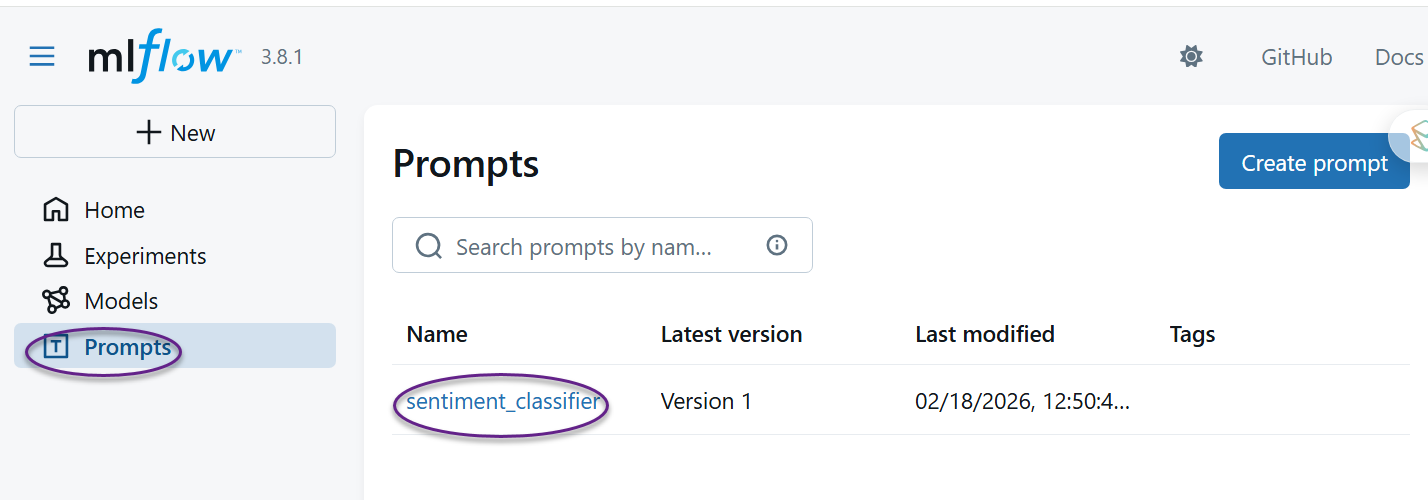 | 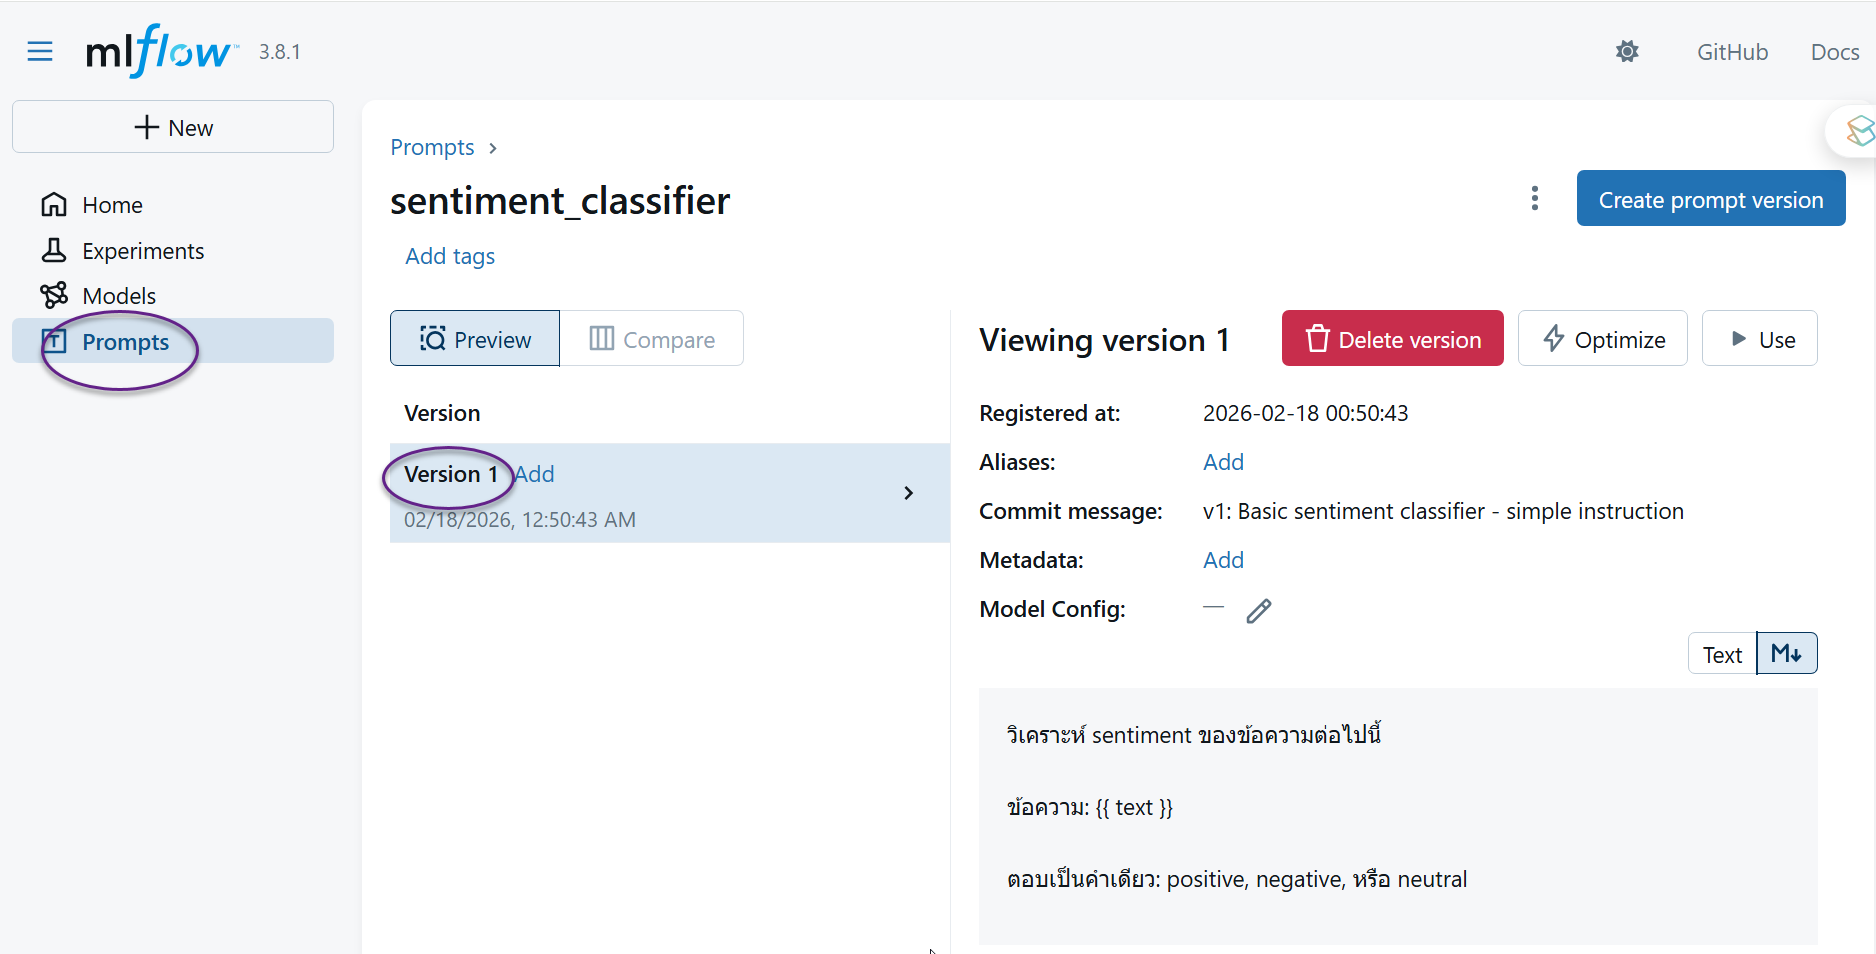 |

In [6]:
# === Lab 2.1: Register Prompt v1 — Sentiment Analysis ===

# กำหนด Prompt Template สำหรับ Sentiment Analysis
PROMPT_NAME = "sentiment_classifier"

PROMPT_TEMPLATE_V1 = """วิเคราะห์ sentiment ของข้อความต่อไปนี้

ข้อความ: {{ text }}

ตอบเป็นคำเดียว: positive, negative, หรือ neutral"""

# ลงทะเบียน Prompt v1
prompt_v1 = mlflow.genai.register_prompt(
    name=PROMPT_NAME,
    template=PROMPT_TEMPLATE_V1,
    commit_message="v1: Basic sentiment classifier - simple instruction"
)



2026/02/17 17:56:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for prompt version to finish creation. Prompt name: sentiment_classifier, version 2


In [7]:
print(f"✅ ลงทะเบียน Prompt สำเร็จ!")
print(f"   Name: {prompt_v1.name}")
print(f"   Version: {prompt_v1.version}")
print(f"   Template:\n{prompt_v1.template}")

✅ ลงทะเบียน Prompt สำเร็จ!
   Name: sentiment_classifier
   Version: 2
   Template:
วิเคราะห์ sentiment ของข้อความต่อไปนี้

ข้อความ: {{ text }}

ตอบเป็นคำเดียว: positive, negative, หรือ neutral


## 2.2 Load Prompt — โหลด Prompt กลับมาใช้งาน

ใช้ `mlflow.genai.load_prompt()` เพื่อโหลด Prompt จาก Registry
แล้วแทนค่าตัวแปรด้วย `.format()` method

**รูปแบบ URI**: `prompts:/<prompt_name>/<version>`
- `prompts:/sentiment_classifier/1` — โหลด version 1
- `prompts:/sentiment_classifier/latest` — โหลด version ล่าสุด

In [8]:
# === Lab 2.2: Load Prompt และใช้งานจริง ===

# โหลด Prompt จาก Registry
loaded_prompt = mlflow.genai.load_prompt(f"prompts:/{PROMPT_NAME}/1")

print(f"📋 Prompt ที่โหลดมา:")
print(f"   Version: {loaded_prompt.version}")
print(f"   Template: {loaded_prompt.template}")

📋 Prompt ที่โหลดมา:
   Version: 1
   Template: วิเคราะห์ sentiment ของข้อความต่อไปนี้

ข้อความ: {{ text }}

ตอบเป็นคำเดียว: positive, negative, หรือ neutral


In [9]:
# แทนค่าตัวแปรและเรียก Gemini API
test_texts = [
    "อาหารร้านนี้อร่อยมากๆ เลย บริการดีสุดๆ",
    "ผิดหวังมาก สินค้าไม่ตรงปก",
    "วันนี้ฝนตกตอนบ่าย"
]

print("🔍 ทดสอบ Prompt v1 กับข้อความตัวอย่าง:\n")

for text in test_texts:
    # แทนค่า {{ text }} ด้วยข้อความจริง
    filled_prompt = loaded_prompt.format(text=text)
    result = call_gemini(filled_prompt)
    print(f"  📝 ข้อความ: {text}")
    print(f"  🏷️  ผลลัพธ์: {result.strip()}")
    print()

🔍 ทดสอบ Prompt v1 กับข้อความตัวอย่าง:



NameError: name 'call_gemini' is not defined

## 2.3 Register Prompt v2 — ปรับปรุง Prompt

ลองปรับปรุง Prompt ให้มีคำอธิบายชัดเจนขึ้น แล้ว Register เป็น Version ใหม่

In [25]:
# === Lab 2.3: Register Prompt v2 — Improved Version ===

PROMPT_TEMPLATE_V2 = """คุณเป็นนักวิเคราะห์ความรู้สึก (Sentiment Analyst) ที่เชี่ยวชาญภาษาไทย

## กฎการวิเคราะห์:
- **positive**: ข้อความแสดงความพึงพอใจ ชื่นชม มีความสุข หรือแนะนำ
- **negative**: ข้อความแสดงความไม่พอใจ ผิดหวัง บ่น หรือวิจารณ์เชิงลบ
- **neutral**: ข้อความเป็นกลาง เป็นข้อเท็จจริง ไม่มีอารมณ์ชัดเจน

## ข้อความที่ต้องวิเคราะห์:
{{ text }}

## คำตอบ (ตอบเพียงคำเดียว: positive, negative, หรือ neutral):"""

# Register เป็น Version ใหม่ (ใช้ชื่อเดิม → MLflow สร้าง version ใหม่อัตโนมัติ)
prompt_v2 = mlflow.genai.register_prompt(
    name=PROMPT_NAME,
    template=PROMPT_TEMPLATE_V2,
    commit_message="v2: Added role, rules, and structured format"
)

print(f"✅ ลงทะเบียน Prompt v2 สำเร็จ!")
print(f"   Name: {prompt_v2.name}")
print(f"   Version: {prompt_v2.version}")

2026/02/17 16:23:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for prompt version to finish creation. Prompt name: sentiment_classifier, version 2


✅ ลงทะเบียน Prompt v2 สำเร็จ!
   Name: sentiment_classifier
   Version: 2


## 2.4 เปรียบเทียบ Prompt v1 vs v2

โหลด Prompt ทั้ง 2 version มาเปรียบเทียบ

In [26]:
# === Lab 2.4: เปรียบเทียบ 2 Versions ===

prompt_v1_loaded = mlflow.genai.load_prompt(f"prompts:/{PROMPT_NAME}/1")
prompt_v2_loaded = mlflow.genai.load_prompt(f"prompts:/{PROMPT_NAME}/2")

print("📊 เปรียบเทียบ Prompt 2 Versions:\n")
print(f"{'='*60}")
print(f"Version 1 (ความยาว: {len(prompt_v1_loaded.template)} ตัวอักษร):")
print(f"{'─'*60}")
print(prompt_v1_loaded.template)
print(f"\n{'='*60}")
print(f"Version 2 (ความยาว: {len(prompt_v2_loaded.template)} ตัวอักษร):")
print(f"{'─'*60}")
print(prompt_v2_loaded.template)

📊 เปรียบเทียบ Prompt 2 Versions:

Version 1 (ความยาว: 109 ตัวอักษร):
────────────────────────────────────────────────────────────
วิเคราะห์ sentiment ของข้อความต่อไปนี้

ข้อความ: {{ text }}

ตอบเป็นคำเดียว: positive, negative, หรือ neutral

Version 2 (ความยาว: 392 ตัวอักษร):
────────────────────────────────────────────────────────────
คุณเป็นนักวิเคราะห์ความรู้สึก (Sentiment Analyst) ที่เชี่ยวชาญภาษาไทย

## กฎการวิเคราะห์:
- **positive**: ข้อความแสดงความพึงพอใจ ชื่นชม มีความสุข หรือแนะนำ
- **negative**: ข้อความแสดงความไม่พอใจ ผิดหวัง บ่น หรือวิจารณ์เชิงลบ
- **neutral**: ข้อความเป็นกลาง เป็นข้อเท็จจริง ไม่มีอารมณ์ชัดเจน

## ข้อความที่ต้องวิเคราะห์:
{{ text }}

## คำตอบ (ตอบเพียงคำเดียว: positive, negative, หรือ neutral):


---
# Part 3: Prompt Testing & Evaluation

สร้างชุดข้อมูลทดสอบ (Test Dataset) และฟังก์ชัน Evaluate
เพื่อวัดประสิทธิภาพของ Prompt แต่ละ Version อย่างเป็นระบบ

## 3.1 สร้าง Test Dataset

ชุดข้อมูลทดสอบพร้อมคำตอบที่ถูกต้อง (Ground Truth) สำหรับวัด Accuracy

In [62]:
# === Lab 3.1: Test Dataset ===

TEST_DATA = [
    # === ประชด / Sarcasm ===
    {"text": "เยี่ยมเลยครับ รอของ 3 อาทิตย์ ได้ของมาชำรุด บริการระดับโลกจริงๆ", "expected": "negative"},
    {"text": "ขอบคุณมากที่ส่งของผิดให้ถึง 2 รอบ ใส่ใจลูกค้าจริงๆ นะคะ", "expected": "negative"},
    {"text": "ราคาแค่นี้เอง ถูกจัง แค่เดือนละหมื่นสองหมื่น ใครๆ ก็ซื้อได้", "expected": "negative"},
    {"text": "ดีค่ะ ดีมากค่ะ ดีจนไม่รู้จะพูดยังไงแล้วค่ะ 🙂", "expected": "negative"},
    
    # === บวกที่ดูเหมือนลบ / Positive disguised as negative ===
    {"text": "แพงจนเสียดาย แต่ต้องยอมรับว่าคุณภาพคุ้มทุกบาท", "expected": "positive"},
    {"text": "เกลียดร้านนี้เลย เพราะมาทีไรก็ใช้เงินเยอะ อร่อยทุกเมนู", "expected": "positive"},

    # === ลบที่ดูเหมือนบวก / Negative disguised as positive ===
    {"text": "บรรจุภัณฑ์สวยงามมากครับ เสียดายข้างในเน่าหมดเลย", "expected": "negative"},
    {"text": "เมนูเยอะดีจัง แต่สั่งอะไรก็หมด เหลือแต่น้ำเปล่า", "expected": "negative"},
    {"text": "ร้านดังจริงๆ ค่ะ ดังจนคิวยาว 3 ชั่วโมง แต่อาหารธรรมดามาก", "expected": "negative"},

    # === กลางที่ดูเหมือนบวก / Neutral disguised as positive ===
    {"text": "ร้านนี้ได้รางวัลร้านยอดเยี่ยมเมื่อปี 2561", "expected": "neutral"},
    {"text": "ลูกค้ารีวิวว่าอร่อยมาก ให้ 4.8 ดาวบน Google", "expected": "neutral"},
    {"text": "เชฟเคยทำงานที่ร้านมิชลินสตาร์ในฝรั่งเศสมาก่อน", "expected": "neutral"},
    {"text": "สินค้าตัวนี้ขายดีอันดับ 1 บนแพลตฟอร์มเดือนที่แล้ว", "expected": "neutral"},
    {"text": "ร้านเปิดสาขาใหม่ 5 สาขาในปีนี้ รวมเป็น 20 สาขาทั่วประเทศ", "expected": "neutral"},

    # === กลางที่ดูเหมือนลบ / Neutral disguised as negative ===
    {"text": "สินค้าหมดสต็อกชั่วคราว คาดว่าจะกลับมาวางขายสัปดาห์หน้า", "expected": "neutral"},
    {"text": "ร้านปิดปรับปรุงวันที่ 1-15 มกราคม", "expected": "neutral"},
    {"text": "นโยบายร้านไม่รับคืนสินค้าหลัง 7 วัน", "expected": "neutral"},
    {"text": "ค่าส่งเริ่มต้น 50 บาท เพิ่มตามน้ำหนัก กิโลกรัมละ 15 บาท", "expected": "neutral"}, 

]

    
print(f"📊 Test Dataset: {len(TEST_DATA)} ข้อ")
print(f"   Positive: {sum(1 for d in TEST_DATA if d['expected'] == 'positive')} ข้อ")
print(f"   Negative: {sum(1 for d in TEST_DATA if d['expected'] == 'negative')} ข้อ")
print(f"   Neutral:  {sum(1 for d in TEST_DATA if d['expected'] == 'neutral')} ข้อ")

📊 Test Dataset: 18 ข้อ
   Positive: 2 ข้อ
   Negative: 7 ข้อ
   Neutral:  9 ข้อ


## 3.2 สร้างฟังก์ชัน Evaluate

ฟังก์ชันสำหรับทดสอบ Prompt กับ Test Dataset ทั้งหมด
แล้วคำนวณ Accuracy พร้อมบันทึกรายละเอียดผลลัพธ์

In [63]:
# === Lab 3.2: Evaluation Function ===

def evaluate_prompt(prompt_template: str, test_data: List[Dict], version_label: str = "") -> Dict:
    """
    ประเมิน Prompt กับชุดข้อมูลทดสอบ
    
    Parameters:
        prompt_template: Prompt template ที่มี {{ text }}
        test_data: ชุดข้อมูลทดสอบ [{text, expected}, ...]
        version_label: ชื่อ version สำหรับแสดงผล
        
    Returns:
        Dict ที่มี accuracy, results, correct, total
    """
    results = []
    correct = 0
    total = len(test_data)
    
    print(f"\n🧪 ทดสอบ Prompt {version_label}")
    print("─" * 60)
    
    for i, item in enumerate(test_data):
        # แทนค่า {{ text }}
        filled = prompt_template.replace("{{ text }}", item["text"])
        
        # เรียก Gemini
        response = call_gemini(filled).strip().lower()
        
        # ตรวจคำตอบ — ดึงเฉพาะ label ที่ตรง
        predicted = "unknown"
        for label in ["positive", "negative", "neutral"]:
            if label in response:
                predicted = label
                break
        
        is_correct = predicted == item["expected"]
        if is_correct:
            correct += 1
        
        result = {
            "text": item["text"],
            "expected": item["expected"],
            "predicted": predicted,
            "raw_response": response,
            "correct": "✅" if is_correct else "❌"
        }
        results.append(result)
        
        print(f"  {result['correct']} [{i+1}/{total}] Expected: {item['expected']:8s} | "
              f"Predicted: {predicted:8s} | {item['text'][:30]}...")
        
        time.sleep(1.5)  # หน่วงเวลาเล็กน้อยเพื่อไม่ให้เกิน Rate Limit
    
    accuracy = (correct / total) * 100
    
    print(f"\n📊 ผลรวม: Accuracy = {accuracy:.1f}% ({correct}/{total})")
    
    return {
        "accuracy": accuracy,
        "correct": correct,
        "total": total,
        "results": results
    }

## 3.3 ทดสอบ Prompt v1 และ v2

In [64]:
# === Lab 3.3: ทดสอบ Prompt v1 ===

prompt_v1_loaded = mlflow.genai.load_prompt(f"prompts:/{PROMPT_NAME}/1")
eval_v1 = evaluate_prompt(prompt_v1_loaded.template, TEST_DATA, version_label="v1")


🧪 ทดสอบ Prompt v1
────────────────────────────────────────────────────────────
  ✅ [1/18] Expected: negative | Predicted: negative | เยี่ยมเลยครับ รอของ 3 อาทิตย์ ...
  ✅ [2/18] Expected: negative | Predicted: negative | ขอบคุณมากที่ส่งของผิดให้ถึง 2 ...
  ❌ [3/18] Expected: negative | Predicted: positive | ราคาแค่นี้เอง ถูกจัง แค่เดือนล...
  ❌ [4/18] Expected: negative | Predicted: positive | ดีค่ะ ดีมากค่ะ ดีจนไม่รู้จะพูด...
  ✅ [5/18] Expected: positive | Predicted: positive | แพงจนเสียดาย แต่ต้องยอมรับว่าค...
  ❌ [6/18] Expected: positive | Predicted: negative | เกลียดร้านนี้เลย เพราะมาทีไรก็...
  ✅ [7/18] Expected: negative | Predicted: negative | บรรจุภัณฑ์สวยงามมากครับ เสียดา...
  ✅ [8/18] Expected: negative | Predicted: negative | เมนูเยอะดีจัง แต่สั่งอะไรก็หมด...
  ✅ [9/18] Expected: negative | Predicted: negative | ร้านดังจริงๆ ค่ะ ดังจนคิวยาว 3...
  ❌ [10/18] Expected: neutral  | Predicted: positive | ร้านนี้ได้รางวัลร้านยอดเยี่ยมเ...
  ❌ [11/18] Expected: neutral  | Predic

In [72]:
# === ทดสอบ Prompt v2 ===

prompt_v2_loaded = mlflow.genai.load_prompt(f"prompts:/{PROMPT_NAME}/2")
eval_v2 = evaluate_prompt(prompt_v2_loaded.template, TEST_DATA, version_label="v2")


🧪 ทดสอบ Prompt v2
────────────────────────────────────────────────────────────
  ✅ [1/18] Expected: negative | Predicted: negative | เยี่ยมเลยครับ รอของ 3 อาทิตย์ ...
  ✅ [2/18] Expected: negative | Predicted: negative | ขอบคุณมากที่ส่งของผิดให้ถึง 2 ...
  ❌ [3/18] Expected: negative | Predicted: positive | ราคาแค่นี้เอง ถูกจัง แค่เดือนล...
  ❌ [4/18] Expected: negative | Predicted: positive | ดีค่ะ ดีมากค่ะ ดีจนไม่รู้จะพูด...
  ✅ [5/18] Expected: positive | Predicted: positive | แพงจนเสียดาย แต่ต้องยอมรับว่าค...
  ❌ [6/18] Expected: positive | Predicted: negative | เกลียดร้านนี้เลย เพราะมาทีไรก็...
  ✅ [7/18] Expected: negative | Predicted: negative | บรรจุภัณฑ์สวยงามมากครับ เสียดา...
  ✅ [8/18] Expected: negative | Predicted: negative | เมนูเยอะดีจัง แต่สั่งอะไรก็หมด...
  ✅ [9/18] Expected: negative | Predicted: negative | ร้านดังจริงๆ ค่ะ ดังจนคิวยาว 3...
  ✅ [10/18] Expected: neutral  | Predicted: neutral  | ร้านนี้ได้รางวัลร้านยอดเยี่ยมเ...
  ❌ [11/18] Expected: neutral  | Predic

In [73]:
# === สรุปเปรียบเทียบ ===

print("\n" + "=" * 60)
print("📊 สรุปผลเปรียบเทียบ Prompt v1 vs v2")
print("=" * 60)
print(f"  Prompt v1: Accuracy = {eval_v1['accuracy']:.1f}% ({eval_v1['correct']}/{eval_v1['total']})")
print(f"  Prompt v2: Accuracy = {eval_v2['accuracy']:.1f}% ({eval_v2['correct']}/{eval_v2['total']})")
improvement = eval_v2['accuracy'] - eval_v1['accuracy']
if improvement > 0:
    print(f"  📈 v2 ดีกว่า v1: +{improvement:.1f}%")
elif improvement < 0:
    print(f"  📉 v1 ดีกว่า v2: {improvement:.1f}%")
else:
    print(f"  ➡️  ผลลัพธ์เท่ากัน")


📊 สรุปผลเปรียบเทียบ Prompt v1 vs v2
  Prompt v1: Accuracy = 50.0% (9/18)
  Prompt v2: Accuracy = 72.2% (13/18)
  📈 v2 ดีกว่า v1: +22.2%


---
# Part 4: Reflection-based Prompt Optimization

ใช้ **Reflection Pattern** ให้ LLM วิเคราะห์จุดอ่อนของ Prompt แล้วสร้าง Prompt ใหม่ที่ดีกว่า

### Reflection Loop:
```
Prompt v_n → ทดสอบ → วิเคราะห์ข้อผิดพลาด → สร้าง Prompt ใหม่ → Prompt v_n+1 → ทดสอบ → ...
```

## 4.1 Reflection for Prompt Optimization

ประยุกต์ Reflection Pattern เข้ากับ **ผลการทดสอบจริง** เพื่อให้ LLM
เห็นข้อผิดพลาดที่เกิดขึ้นและเสนอ Prompt ใหม่ที่ตรงจุด

ฟังก์ชันนี้จะ:
1. รับ Prompt ปัจจุบันและผลการทดสอบ
2. ส่งให้ Gemini วิเคราะห์จุดอ่อนจากข้อที่ตอบผิด
3. ให้ Gemini สร้าง Prompt ใหม่ที่แก้ปัญหาเหล่านั้น

In [33]:
# === Lab 4.2: Prompt Optimization with Reflection ===

def optimize_prompt_with_reflection(
    current_template: str,
    eval_results: Dict,
    version_label: str = ""
) -> str:
    """
    ใช้ Reflection เพื่อปรับปรุง Prompt จากผลการทดสอบ
    
    Parameters:
        current_template: Prompt template ปัจจุบัน
        eval_results: ผลจาก evaluate_prompt()
        version_label: ชื่อ version สำหรับแสดงผล
    
    Returns:
        Prompt template ใหม่ที่ปรับปรุงแล้ว
    """
    accuracy = eval_results["accuracy"]
    correct = eval_results["correct"]
    total = eval_results["total"]
    results = eval_results["results"]
    
    # ดึงเฉพาะข้อที่ตอบผิด
    wrong_answers = [r for r in results if r['correct'] == '❌']
    
    if not wrong_answers:
        print("✅ Prompt ได้ 100% แล้ว ไม่ต้องปรับปรุง!")
        return current_template
    
    # สร้าง Reflection Prompt
    reflection_request = f"""คุณเป็นผู้เชี่ยวชาญด้าน Prompt Engineering

## Prompt ปัจจุบัน:
{current_template}

## ผลการทดสอบ:
- Accuracy: {accuracy:.1f}% ({correct}/{total})
- จำนวนข้อที่ผิด: {total - correct} ข้อ

## ตัวอย่างข้อที่ตอบผิด:
{json.dumps(wrong_answers, ensure_ascii=False, indent=2)}

## คำสั่ง:
1. **จุดอ่อนของ Prompt ปัจจุบัน** — อะไรทำให้ตอบผิด?
2. **Prompt ใหม่ที่ปรับปรุงแล้ว** — เขียนใหม่ทั้งหมด ใช้ตัวแปร {{{{ text }}}}
   คำตอบต้องเป็นคำเดียว: positive, negative, หรือ neutral
3. **สิ่งที่เปลี่ยนแปลง** — อธิบายว่าแก้อะไร ทำไมน่าจะดีกว่า

⚠️ ส่วน Prompt ใหม่ ให้ขึ้นต้นด้วย [NEW_PROMPT_START] และจบด้วย [NEW_PROMPT_END]"""
    
    print_section(f"🔍 Reflection Analysis ({version_label})", 
                  f"กำลังวิเคราะห์ {len(wrong_answers)} ข้อที่ตอบผิด...", "🤔")
    
    # เรียก Gemini เพื่อวิเคราะห์และสร้าง Prompt ใหม่
    reflection_response = call_gemini(reflection_request, temperature=0.3, max_tokens=4096)
    print_section("Reflection Result", reflection_response, "💡")
    
    # ดึง Prompt ใหม่จากผลลัพธ์
    new_prompt = extract_new_prompt(reflection_response)
    
    if new_prompt:
        print_section("New Prompt Extracted", new_prompt, "🆕")
    else:
        print("⚠️ ไม่สามารถดึง Prompt ใหม่ได้ ใช้ Prompt เดิม")
        new_prompt = current_template
    
    return new_prompt


def extract_new_prompt(response: str) -> str:
    """ดึง Prompt ใหม่จากระหว่าง [NEW_PROMPT_START] และ [NEW_PROMPT_END]"""
    start_marker = "[NEW_PROMPT_START]"
    end_marker = "[NEW_PROMPT_END]"
    
    if start_marker in response and end_marker in response:
        start_idx = response.index(start_marker) + len(start_marker)
        end_idx = response.index(end_marker)
        return response[start_idx:end_idx].strip()
    
    return None

## 4.3 ทดลอง Optimize Prompt v2

นำผลการทดสอบ Prompt v2 มาให้ Reflection วิเคราะห์และสร้าง Prompt v3

In [82]:
# === Lab 4.3: Optimize v2 → v3 ===
# ใช้ผลทดสอบ v2 จาก Part 3
new_template_v3 = optimize_prompt_with_reflection(current_template=prompt_v2_loaded.template,eval_results=eval_v2,version_label="v2 → v3")


🤔 🔍 Reflection Analysis (v2 → v3)
──────────────────────────────────────────────────
กำลังวิเคราะห์ 5 ข้อที่ตอบผิด...
──────────────────────────────────────────────────

💡 Reflection Result
──────────────────────────────────────────────────
## 1. จุดอ่อนของ Prompt ปัจจุบัน

Prompt ปัจจุบันมีจุดอ่อนหลักๆ คือ:

*   **ขาดความเข้าใจในประชดประชันและเสียดสี:** ตัวอย่างเช่น "ราคาแค่นี้เอง ถูกจัง แค่เดือนละหมื่นสองหมื่น ใครๆ ก็ซื้อได้" เป็นการประชดประชันว่าราคาแพง แต่ Prompt ตีความว่าเป็น positive เพราะเห็นคำว่า "ถูกจัง"
*   **ขาดความเข้าใจในอารมณ์ที่ซับซ้อน:** ตัวอย่างเช่น "ดีค่ะ ดีมากค่ะ ดีจนไม่รู้จะพูดยังไงแล้วค่ะ 🙂" แม้จะมีอีโมจิยิ้ม แต่การที่ "ดีจนไม่รู้จะพูดยังไงแล้วค่ะ" อาจเป็นการแสดงความไม่พอใจแบบอ้อมๆ หรือเบื่อหน่าย
*   **ให้ความสำคัญกับคำหลักมากเกินไป:** ตัวอย่างเช่น "เกลียดร้านนี้เลย เพราะมาทีไรก็ใช้เงินเยอะ อร่อยทุกเมนู" มีคำว่า "เกลียด" ทำให้ Prompt ตีความเป็น negative ทั้งที่เหตุผลที่เกลียดคืออร่อยจนใช้เงินเยอะ ซึ่งแสดงถึงความชอบ
*   **ตีความข้อมูลที่เป็นข้อเท็จจริงเป็นการแสดงคว

In [83]:
print(new_template_v3)

คุณเป็นนักวิเคราะห์ความรู้สึก (Sentiment Analyst) ที่เชี่ยวชาญภาษาไทย มีหน้าที่วิเคราะห์ข้อความและระบุว่าเป็น positive, negative หรือ neutral โดยพิจารณาจากบริบทและความหมายโดยรวมของข้อความ ไม่ใช่แค่คำบางคำ

**กฎการวิเคราะห์:**

*   **positive:** ข้อความแสดงความพึงพอใจ ชื่นชม ชอบ สนับสนุน หรือแนะนำ (รวมถึงการแสดงความไม่พอใจเล็กน้อยที่ตามมาด้วยเหตุผลที่ดี เช่น "แพงไปหน่อยแต่อร่อยมาก")
*   **negative:** ข้อความแสดงความไม่พอใจ ผิดหวัง บ่น วิจารณ์เชิงลบ หรือประชดประชัน (รวมถึงการแสดงความพึงพอใจแบบประชดประชัน)
*   **neutral:** ข้อความเป็นกลาง เป็นข้อเท็จจริง ข้อมูลสถิติ หรือการรายงานเหตุการณ์ที่ไม่มีอารมณ์ชัดเจน (เช่น ข่าว ประกาศ)

**ข้อควรระวัง:**

*   **ประชดประชัน:** ระวังการตีความผิดพลาดจากข้อความที่ประชดประชันหรือเสียดสี
*   **บริบท:** พิจารณาบริบทของข้อความทั้งหมด ไม่ใช่แค่คำบางคำ
*   **เหตุผล:** พิจารณาเหตุผลที่อยู่เบื้องหลังความรู้สึกที่แสดงออกมา

**ข้อความที่ต้องวิเคราะห์:**
{{ text }}

**คำตอบ (ตอบเพียงคำเดียว: positive, negative, หรือ neutral):**


## 4.4 Register และทดสอบ Prompt v3

In [84]:
# === Lab 4.4: Register v3 ===

prompt_v3 = mlflow.genai.register_prompt(
    name=PROMPT_NAME,
    template=new_template_v3,
    commit_message="v3: Reflection-optimized from v2 test results")


print(f"✅ ลงทะเบียน Prompt v3 สำเร็จ! (Version: {prompt_v3.version})")


2026/02/17 16:59:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for prompt version to finish creation. Prompt name: sentiment_classifier, version 4


✅ ลงทะเบียน Prompt v3 สำเร็จ! (Version: 4)


In [85]:
# ทดสอบ Prompt v3
prompt_v3_loaded = mlflow.genai.load_prompt(f"prompts:/{PROMPT_NAME}/3")
eval_v3 = evaluate_prompt(prompt_v3_loaded.template, TEST_DATA, version_label="v3")


🧪 ทดสอบ Prompt v3
────────────────────────────────────────────────────────────
  ✅ [1/18] Expected: negative | Predicted: negative | เยี่ยมเลยครับ รอของ 3 อาทิตย์ ...
  ✅ [2/18] Expected: negative | Predicted: negative | ขอบคุณมากที่ส่งของผิดให้ถึง 2 ...
  ✅ [3/18] Expected: negative | Predicted: negative | ราคาแค่นี้เอง ถูกจัง แค่เดือนล...
  ❌ [4/18] Expected: negative | Predicted: positive | ดีค่ะ ดีมากค่ะ ดีจนไม่รู้จะพูด...
  ✅ [5/18] Expected: positive | Predicted: positive | แพงจนเสียดาย แต่ต้องยอมรับว่าค...
  ❌ [6/18] Expected: positive | Predicted: negative | เกลียดร้านนี้เลย เพราะมาทีไรก็...
  ✅ [7/18] Expected: negative | Predicted: negative | บรรจุภัณฑ์สวยงามมากครับ เสียดา...
  ✅ [8/18] Expected: negative | Predicted: negative | เมนูเยอะดีจัง แต่สั่งอะไรก็หมด...
  ✅ [9/18] Expected: negative | Predicted: negative | ร้านดังจริงๆ ค่ะ ดังจนคิวยาว 3...
  ✅ [10/18] Expected: neutral  | Predicted: neutral  | ร้านนี้ได้รางวัลร้านยอดเยี่ยมเ...
  ❌ [11/18] Expected: neutral  | Predic

---
# Part 5: Full Optimization Loop & Comparison

รวมทุกอย่างเป็น **Optimization Loop** ที่ทำซ้ำได้:
1. ทดสอบ Prompt ปัจจุบัน
2. ถ้า Accuracy ไม่ถึงเป้าหมาย → Reflection → สร้าง Prompt ใหม่
3. Register Version ใหม่ → ทดสอบอีกครั้ง
4. ทำซ้ำจนกว่าจะถึงเป้าหมายหรือครบจำนวนรอบ

In [36]:
# === Lab 5: Full Optimization Loop ===

def prompt_optimization_loop(
    prompt_name: str,
    initial_template: str,
    test_data: List[Dict],
    target_accuracy: float = 100.0,
    max_iterations: int = 3
) -> Dict:
    """
    Optimization Loop: ทดสอบ → Reflect → ปรับปรุง → ทดสอบ → ...
    
    Parameters:
        prompt_name: ชื่อ Prompt ใน MLflow Registry
        initial_template: Prompt template เริ่มต้น
        test_data: ชุดข้อมูลทดสอบ
        target_accuracy: เป้าหมาย Accuracy (%)
        max_iterations: จำนวนรอบสูงสุด
    
    Returns:
        Dict สรุปผลทุก iteration
    """
    history = []
    current_template = initial_template
    
    print("🚀 เริ่ม Prompt Optimization Loop")
    print(f"   เป้าหมาย: Accuracy >= {target_accuracy}%")
    print(f"   จำนวนรอบสูงสุด: {max_iterations}")
    print("=" * 60)
    
    for iteration in range(1, max_iterations + 1):
        print(f"\n{'='*60}")
        print(f"🔄 Iteration {iteration}/{max_iterations}")
        print(f"{'='*60}")
        
        # Step 1: Evaluate
        eval_result = evaluate_prompt(
            current_template, test_data, 
            version_label=f"Iter-{iteration}"
        )
        
        history.append({
            "iteration": iteration,
            "accuracy": eval_result["accuracy"],
            "correct": eval_result["correct"],
            "total": eval_result["total"],
            "template": current_template
        })
        
        # Step 2: Check target
        if eval_result["accuracy"] >= target_accuracy:
            print(f"\n🎉 ถึงเป้าหมายแล้ว! Accuracy = {eval_result['accuracy']:.1f}%")
            break
        
        # Step 3: Reflect & Optimize
        print(f"\n🔍 ยังไม่ถึงเป้าหมาย ({eval_result['accuracy']:.1f}% < {target_accuracy}%)")
        print(f"   กำลัง Reflect และปรับปรุง...")
        
        new_template = optimize_prompt_with_reflection(
            current_template, eval_result,
            version_label=f"Iter-{iteration}"
        )
        
        # Step 4: Register ถ้ามีการเปลี่ยนแปลง
        if new_template != current_template:
            registered = mlflow.genai.register_prompt(
                name=prompt_name,
                template=new_template,
                commit_message=f"Optimization iteration {iteration}: "
                             f"Accuracy {eval_result['accuracy']:.1f}% → improving"
            )
            print(f"   ✅ Registered new version: {registered.version}")
            current_template = new_template
        else:
            print("   ⚠️ Prompt ไม่เปลี่ยนแปลง หยุด Loop")
            break
    
    # === สรุปผล ===
    print(f"\n{'='*60}")
    print("📊 สรุปผล Optimization Loop")
    print(f"{'='*60}")
    for h in history:
        bar = "█" * int(h["accuracy"] / 5)
        print(f"  Iter {h['iteration']}: {bar} {h['accuracy']:.1f}% ({h['correct']}/{h['total']})")
    
    if len(history) > 1:
        improvement = history[-1]["accuracy"] - history[0]["accuracy"]
        print(f"\n  📈 การปรับปรุงรวม: {'+' if improvement >= 0 else ''}{improvement:.1f}%")
    
    return {
        "history": history,
        "final_template": current_template,
        "iterations": len(history)
    }

## 5.1 รัน Optimization Loop

เริ่มจาก Prompt v1 (Basic) แล้วให้ระบบปรับปรุงอัตโนมัติ

In [37]:
# === Lab 5.1: Run Full Optimization ===

# เริ่มจาก Prompt v1 (พื้นฐานที่สุด)
starting_prompt = mlflow.genai.load_prompt(f"prompts:/{PROMPT_NAME}/1")

optimization_result = prompt_optimization_loop(
    prompt_name=PROMPT_NAME,
    initial_template=starting_prompt.template,
    test_data=TEST_DATA,
    target_accuracy=100.0,
    max_iterations=3
)

🚀 เริ่ม Prompt Optimization Loop
   เป้าหมาย: Accuracy >= 100.0%
   จำนวนรอบสูงสุด: 3

🔄 Iteration 1/3

🧪 ทดสอบ Prompt Iter-1
────────────────────────────────────────────────────────────
  ✅ [1/10] Expected: positive | Predicted: positive | สินค้าดีมาก คุ้มค่าเงิน จะกลับ...
  ✅ [2/10] Expected: negative | Predicted: negative | ส่งช้ามาก รอเป็นอาทิตย์ ผิดหวั...
  ✅ [3/10] Expected: neutral  | Predicted: neutral  | ร้านเปิดทุกวัน เวลา 9:00-18:00...
  ✅ [4/10] Expected: positive | Predicted: positive | อาหารรสชาติดี บรรยากาศร้านก็สว...
  ✅ [5/10] Expected: negative | Predicted: negative | ของเสียง่าย ใช้ได้ไม่ถึงเดือน...
  ❌ [6/10] Expected: neutral  | Predicted: positive | ร้านอยู่ติดกับสถานี BTS สยาม...
  ✅ [7/10] Expected: positive | Predicted: positive | พนักงานบริการดีมาก ยิ้มแย้มแจ่...
  ✅ [8/10] Expected: negative | Predicted: negative | แพงเกินไป ไม่คุ้มเลย...
  ✅ [9/10] Expected: neutral  | Predicted: neutral  | สินค้ามีทั้งขนาด S M L XL...
  ✅ [10/10] Expected: positive | Predic

2026/02/17 16:25:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for prompt version to finish creation. Prompt name: sentiment_classifier, version 3



💡 Reflection Result
──────────────────────────────────────────────────
## 1. จุดอ่อนของ Prompt ปัจจุบัน

จุดอ่อนของ Prompt ปัจจุบันคือ **ความไม่ชัดเจนในการจัดการกับข้อความที่เป็นกลาง (neutral)** Prompt เน้นเพียงแค่การแยกแยะระหว่าง positive และ negative ทำให้ AI มีแนวโน้มที่จะตีความข้อความที่ไม่มีอารมณ์ความรู้สึกชัดเจนว่าเป็น positive โดยเฉพาะอย่างยิ่งเมื่อข้อความนั้นเกี่ยวข้องกับสถานที่หรือสิ่งของที่โดยทั่วไปถือว่าดี (เช่น สถานี BTS สยาม) AI อาจตีความว่าการกล่าวถึงสถานที่ดังกล่าวเป็นการแสดงความพึงพอใจ

## 2. Prompt ใหม่ที่ปรับปรุงแล้ว

[NEW_PROMPT_START]

วิเคราะห์ sentiment ของข้อความต่อไปนี้อย่างละเอียด โดยพิจารณาถึงอารมณ์ความรู้สึกที่แสดงออกมาอย่างชัดเจน หากข้อความไม่ได้แสดงอารมณ์ความรู้สึกใดๆ หรือเป็นเพียงข้อมูลที่เป็นข้อเท็จจริง ให้ระบุว่าเป็นกลาง

ข้อความ: {{ text }}

ตอบเป็นคำเดียว: positive, negative, หรือ neutral

[NEW_PROMPT_END]

## 3. สิ่งที่เปลี่ยนแปลง

การเปลี่ยนแปลงหลักคือการเพิ่มคำแนะนำที่ชัดเจนยิ่งขึ้นเกี่ยวกับการจัดการกับข้อความที่เป็นกลาง (neutral) โดยเฉพาะอย่างยิ่ง

{'history': [{'iteration': 1, 'accuracy': 90.0, 'correct': 9, 'total': 10, 'template': 'วิเคราะห์ sentiment ของข้อความต่อไปนี้\n\nข้อความ: {{ text }}\n\nตอบเป็นคำเดียว: positive, negative, หรือ neutral'}, {'iteration': 2, 'accuracy': 100.0, 'correct': 10, 'total': 10, 'template': 'วิเคราะห์ sentiment ของข้อความต่อไปนี้อย่างละเอียด โดยพิจารณาถึงอารมณ์ความรู้สึกที่แสดงออกมาอย่างชัดเจน หากข้อความไม่ได้แสดงอารมณ์ความรู้สึกใดๆ หรือเป็นเพียงข้อมูลที่เป็นข้อเท็จจริง ให้ระบุว่าเป็นกลาง\n\nข้อความ: {{ text }}\n\nตอบเป็นคำเดียว: positive, negative, หรือ neutral'}], 'final_template': 'วิเคราะห์ sentiment ของข้อความต่อไปนี้อย่างละเอียด โดยพิจารณาถึงอารมณ์ความรู้สึกที่แสดงออกมาอย่างชัดเจน หากข้อความไม่ได้แสดงอารมณ์ความรู้สึกใดๆ หรือเป็นเพียงข้อมูลที่เป็นข้อเท็จจริง ให้ระบุว่าเป็นกลาง\n\nข้อความ: {{ text }}\n\nตอบเป็นคำเดียว: positive, negative, หรือ neutral', 'iterations': 2}


## 5.2 เปรียบเทียบผลลัพธ์ทุก Version พร้อม MLflow Tracking

In [39]:
# === Lab 5.2: Log ทุกอย่างลง MLflow ===

mlflow.set_experiment("prompt_optimization_lab")

with mlflow.start_run(run_name="prompt_versions_comparison"):
    # Log ผลลัพธ์แต่ละ iteration
    for h in optimization_result["history"]:
        mlflow.log_metric(f"accuracy_iter_{h['iteration']}", h["accuracy"])
        mlflow.log_metric(f"correct_iter_{h['iteration']}", h["correct"])
    
    # Log ค่าสรุป
    mlflow.log_metric("final_accuracy", optimization_result["history"][-1]["accuracy"])
    mlflow.log_metric("total_iterations", optimization_result["iterations"])
    
    if len(optimization_result["history"]) > 1:
        improvement = (optimization_result["history"][-1]["accuracy"] 
                      - optimization_result["history"][0]["accuracy"])
        mlflow.log_metric("total_improvement", improvement)
    
    # Log Prompt template สุดท้าย
    mlflow.log_param("final_prompt_template", optimization_result["final_template"][:250])
    mlflow.log_param("prompt_name", PROMPT_NAME)
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("test_data_size", len(TEST_DATA))
    
    print("✅ บันทึกผลลัพธ์ลง MLflow เรียบร้อย!")
    print(f"   Experiment: prompt_optimization_lab")
    print(f"   ดูผลลัพธ์ได้ที่: {MLFLOW_TRACKING_URI}")

✅ บันทึกผลลัพธ์ลง MLflow เรียบร้อย!
   Experiment: prompt_optimization_lab
   ดูผลลัพธ์ได้ที่: http://127.0.0.1:5000
🏃 View run prompt_versions_comparison at: http://127.0.0.1:5000/#/experiments/2/runs/93e96b8e7637497da31e7a2d370521ea
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## 5.3 ดู Prompt ทุก Version ใน Registry

In [40]:
# === Lab 5.3: แสดง Prompt ทุก Version ===

print(f"📋 Prompt Versions ใน Registry: '{PROMPT_NAME}'\n")

version = 1
while True:
    try:
        p = mlflow.genai.load_prompt(f"prompts:/{PROMPT_NAME}/{version}")
        print(f"{'='*60}")
        print(f"📌 Version {version}")
        print(f"{'─'*60}")
        print(p.template[:200] + ("..." if len(p.template) > 200 else ""))
        print()
        version += 1
    except Exception:
        break

print(f"รวมทั้งหมด: {version - 1} versions")

📋 Prompt Versions ใน Registry: 'sentiment_classifier'

📌 Version 1
────────────────────────────────────────────────────────────
วิเคราะห์ sentiment ของข้อความต่อไปนี้

ข้อความ: {{ text }}

ตอบเป็นคำเดียว: positive, negative, หรือ neutral

📌 Version 2
────────────────────────────────────────────────────────────
คุณเป็นนักวิเคราะห์ความรู้สึก (Sentiment Analyst) ที่เชี่ยวชาญภาษาไทย

## กฎการวิเคราะห์:
- **positive**: ข้อความแสดงความพึงพอใจ ชื่นชม มีความสุข หรือแนะนำ
- **negative**: ข้อความแสดงความไม่พอใจ ผิดหว...

📌 Version 3
────────────────────────────────────────────────────────────
วิเคราะห์ sentiment ของข้อความต่อไปนี้อย่างละเอียด โดยพิจารณาถึงอารมณ์ความรู้สึกที่แสดงออกมาอย่างชัดเจน หากข้อความไม่ได้แสดงอารมณ์ความรู้สึกใดๆ หรือเป็นเพียงข้อมูลที่เป็นข้อเท็จจริง ให้ระบุว่าเป็นกลาง...

รวมทั้งหมด: 3 versions


---
# 🎯 สรุป Lab

## สิ่งที่ได้เรียนรู้:
1. **MLflow Prompt Registry** — จัดการ Prompt แบบมี Version Control
   - `mlflow.genai.register_prompt()` → บันทึก Prompt พร้อม commit message
   - `mlflow.genai.load_prompt()` → โหลด Prompt ตาม version
   - `.format()` → แทนค่าตัวแปรใน template

2. **Prompt Evaluation** — วัดประสิทธิภาพอย่างเป็นระบบ
   - สร้าง Test Dataset พร้อม Ground Truth
   - คำนวณ Accuracy แยกรายข้อ

3. **Reflection Pattern** — ใช้ LLM วิเคราะห์ตัวเอง
   - Generate → Reflect → Improve
   - นำผลทดสอบจริงมาวิเคราะห์จุดอ่อน

4. **Optimization Loop** — ปรับปรุงอัตโนมัติ
   - Test → Reflect → Optimize → Register → Test → ...
   - ติดตามผลผ่าน MLflow Tracking

## แบบฝึกหัดเพิ่มเติม:
- ลองเพิ่มข้อมูลทดสอบให้ยากขึ้น (เช่น ข้อความเสียดสี, ข้อความกำกวม)
- ปรับ `temperature` ใน Reflection ให้สูงขึ้นเพื่อให้ได้ Prompt ที่หลากหลาย
- เปรียบเทียบผลระหว่างโมเดล Gemini ต่างๆ (เช่น flash vs pro)